In [11]:
import wfdb
from wfdb import processing
import numpy as np
import scipy
import matplotlib.pyplot as plt
from matplotlib import figure
from scipy.fft import fft, ifft
from scipy import signal
import math
import seaborn as sns

In [76]:
def load_data(path):
    """Loads database file and returns ECG signal samples and fields list"""
    try:
        signals, fields = wfdb.rdsamp(path)
        ECG = signals[:,0]
        return ECG, fields
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None


def remove_baseline_wander_fft(ekg_data, sampling_rate=4, cutoff_frequency=0.5):
    """Removes the baseline wander for better manipulation with data. Using Fourier Transformation
    to locate lowfrequency components and erasing them."""
    spectrum = fft(ekg_data)
    freq = np.fft.fftfreq(len(ekg_data), 1/sampling_rate)
    spectrum[(freq > -cutoff_frequency) & (freq < cutoff_frequency)] = 0
    ekg_without_baseline = np.real(ifft(spectrum))
    return ekg_without_baseline


def find_Rpeaks(ecg_flatten_signal, samp_rate):
    """Finds R peaks in ECG signal with dynamically changing window size.
    Returns a list of peaks and corresponding times."""
    margin = int(samp_rate/3)
    max_window_size = int(samp_rate)

    r_peaks = []
    current_position = 0
    signal_avg = (np.max(ecg_flatten_signal) + np.min(ecg_flatten_signal))*3 / 4

    while current_position < len(ecg_flatten_signal):
        window_size = min(max_window_size, len(ecg_flatten_signal) - current_position - 1)
        window_signal = ecg_flatten_signal[current_position: current_position + window_size]

        if not window_signal.any():
            current_position += margin
            continue

        max_value = window_signal[0]
        max_position_in_window = 0
        max_position_in_window = np.argmax(window_signal)

        max_position_in_signal = current_position + max_position_in_window
        if ecg_flatten_signal[max_position_in_signal] > signal_avg:
            r_peaks.append(max_position_in_signal)

        current_position = max_position_in_signal + margin

    return r_peaks

def preprocess_signals(signals, samp_rates):
    dominant_samp_rate = max(set(samp_rates), key=samp_rates.count)

    synchronized_signals = []
    outed_signals = []
    for i, (signal, samp_rate) in enumerate(zip(signals, samp_rates)):
        if samp_rate != dominant_samp_rate:
            signals[i] = scipy.signal.resample(signal, int(len(signal) * dominant_samp_rate / samp_rate))
        else:
            signals[i] = signal

    for i, signal in enumerate(signals):
        R_peaks_positions = find_Rpeaks(signal, dominant_samp_rate)
        if len(R_peaks_positions) < 1000:
            outed_signals.append(i)
            continue
        else:
            synchronized_signal = signal[R_peaks_positions[0]:]
            synchronized_signals.append(synchronized_signal)

    min_length = min(len(signal) for signal in synchronized_signals)
    final_signals = [signal[:min_length] for signal in synchronized_signals]

    return final_signals

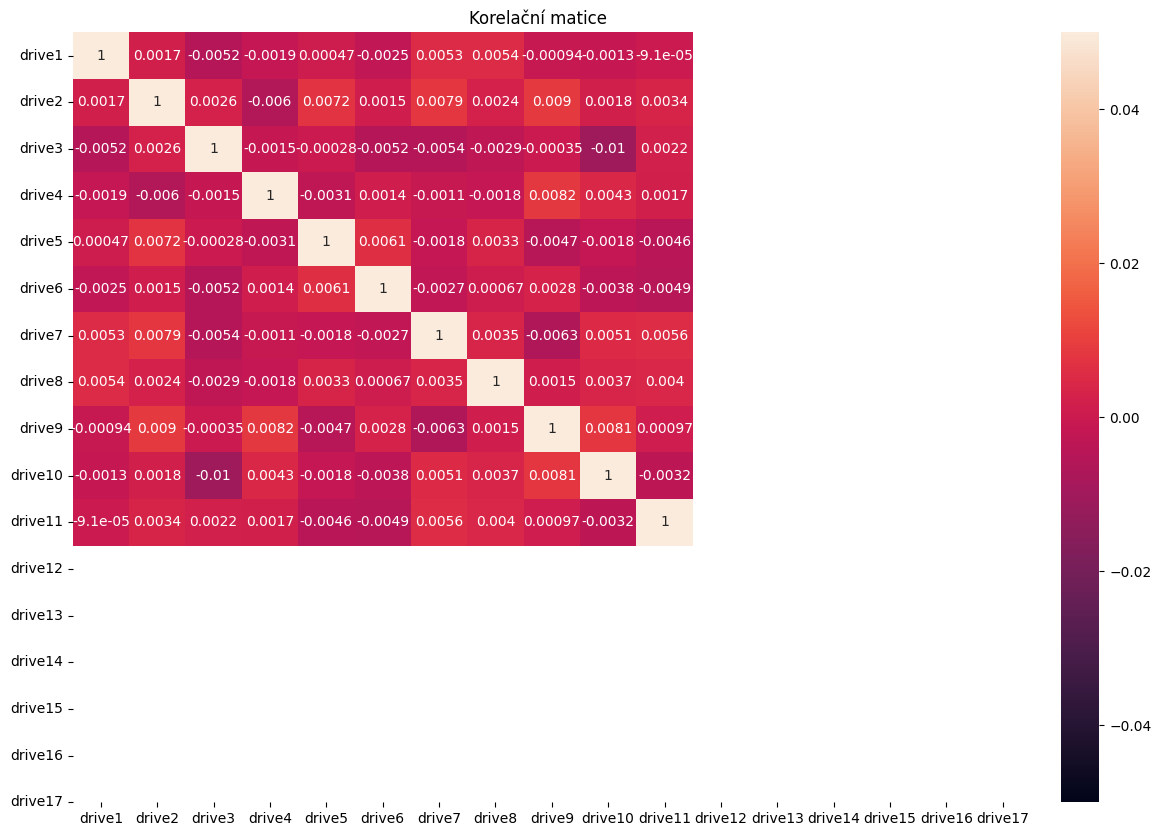

In [77]:
signals = []
samps = []

size = 17

for i in range(1, size):
    ecg, fields = load_data('Database/drive%s' %str(i).zfill(2))
    samp_rate = fields['fs']

    signals.append(remove_baseline_wander_fft(ecg, samp_rate))
    samps.append(samp_rate)


final_signals= preprocess_signals(signals, samps)

correlation_matrix = np.corrcoef(final_signals)

plt.figure(figsize=(15,10))
plt.title("Korelační matice")
sns.heatmap(correlation_matrix, annot=True,
            xticklabels=list(map(lambda x: "drive%s" % x, range(1, size + 1))),
            yticklabels=list(map(lambda x: "drive%s" % x, range(1, size + 1))),
            vmin= -0.05, vmax= 0.05)
plt.show()

